
## Importing data

In [1]:
import numpy as np
import pandas as pd
from itertools import groupby
from sklearn.model_selection import train_test_split
from pandas.api.types import is_datetime64_ns_dtype

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
import lightgbm as lgb
from imblearn.under_sampling import RandomUnderSampler
from joblib import Parallel, delayed
import gc
import plotly.express as px

import warnings
warnings.filterwarnings("ignore")

from metric import score # Import event detection ap score function

# These are variables to be used by the score function
column_names = {
    'series_id_column_name': 'series_id',
    'time_column_name': 'step',
    'event_column_name': 'event',
    'score_column_name': 'score',
}

tolerances = {
    'onset': [12, 36, 60, 90, 120, 150, 180, 240, 300, 360], 
    'wakeup': [12, 36, 60, 90, 120, 150, 180, 240, 300, 360]
}

In [2]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.dates as mdates
import seaborn as sns

import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px
import plotly.offline

In [3]:
def reduce_mem_usage(df):
    
    """ 
    Iterate through all numeric columns of a dataframe and modify the data type
    to reduce memory usage.        
    """
    
    for col in df.columns:
        col_type = df[col].dtype

        if col_type != object and not is_datetime64_ns_dtype(df[col]) and not 'category':
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int32)  
            else:
                df[col] = df[col].astype(np.float16)
        
    return df

In [4]:
def feat_eng(df):
    
    df['series_id'] = df['series_id'].astype('category')
    df['timestamp'] = pd.to_datetime(df['timestamp']).apply(lambda t: t.tz_localize(None))
    df['hour'] = df["timestamp"].dt.hour
    
    df.sort_values(['timestamp'], inplace=True)
    df.set_index('timestamp', inplace=True)
    
    df['lids'] = np.maximum(0., df['enmo'] - 0.02)
    df['lids'] = df['lids'].rolling(f'{120*5}s', center=True, min_periods=1).agg('sum')
    df['lids'] = 100 / (df['lids'] + 1)
    df['lids'] = df['lids'].rolling(f'{360*5}s', center=True, min_periods=1).agg('mean').astype(np.float32)
    
    df["enmo"] = (df["enmo"]*1000)#.astype(np.float64)#.astype(np.int16)
    df["anglez"] = df["anglez"]#.astype(np.float64)#.astype(np.int16)
    df["anglezdiffabs"] = df["anglez"].diff().abs()#.astype(np.float64)
    
    for col in ['enmo', 'anglez', 'anglezdiffabs']:
        
        # periods in seconds        
        periods = [60, 360, 720, 3600] 
        
        for n in periods:
            
            rol_args = {'window':f'{n+5}s', 'min_periods':10, 'center':True}
            
            for agg in ['median', 'mean', 'max', 'min', 'var']:
                df[f'{col}_{agg}_{n}'] = df[col].rolling(**rol_args).agg(agg)#.astype(np.float64).values
                gc.collect()
            
            if n == max(periods):
                df[f'{col}_mad_{n}'] = (df[col] - df[f'{col}_median_{n}']).abs().rolling(**rol_args).median().astype(np.float32)
            
            df[f'{col}_amplit_{n}'] = df[f'{col}_max_{n}']-df[f'{col}_min_{n}']
            df[f'{col}_amplit_{n}_min'] = df[f'{col}_amplit_{n}'].rolling(**rol_args).min().astype(np.float32).values
            
#             if col in ['enmo', 'anglez']:
            df[f'{col}_diff_{n}_max'] = df[f'{col}_max_{n}'].diff().abs().rolling(**rol_args).max().astype(np.float32)
            df[f'{col}_diff_{n}_mean'] = df[f'{col}_max_{n}'].diff().abs().rolling(**rol_args).mean().astype(np.float32)

    
            gc.collect()
    
    df.reset_index(inplace=True)
    df.dropna(inplace=True)

    return df

In [5]:
file = '/kaggle/input/gamma-train-series-updated-11-11-2023/train_series_10112023.parquet'

def feat_eng_by_id(idx):
    
    from warnings import simplefilter 
    simplefilter(action="ignore", category=pd.errors.PerformanceWarning)
    
    df  = pd.read_parquet(file, filters=[('series_id','=',idx)])
    df = feat_eng(df)
    
    return df

file

'/kaggle/input/gamma-train-series-updated-11-11-2023/train_series_10112023.parquet'

## Training and validating 

In [6]:
DEV = False

series_id  = pd.read_parquet(file, columns=['series_id'])
series_id = series_id.series_id.unique()

print(len(series_id))

if DEV:
    series_id = series_id[::10]

269


In [7]:
series_id

array(['038441c925bb', '03d92c9f6f8a', '0402a003dae9', '04f547b8017d',
       '05e1944c3818', '062cae666e2a', '062dbd4c95e6', '08db4255286f',
       '0a96f4993bd7', '0cd1e3d0ed95', '0ce74d6d2106', '0cfc06c129cc',
       '0d0ad1e77851', '0dee4fda51c3', '0ec9fc461819', '0ef7d94fde99',
       '0f572d690310', '10469f6765bf', '1087d7b0ff2e', '10f8bc1f7b07',
       '12d01911d509', '1319a1935f48', '137771d19ca2', '137b99e936ab',
       '13b4d6a01d27', '148471991ffb', '154fe824ed87', '16fe2798ed0f',
       '1716cd4163b2', '1762ab70ec76', '188d4b7cd28b', '18a0ca03431d',
       '18b61dd5aae8', '1955d568d987', '1b92be89db4c', '1c7c0bad1263',
       '1d4569cbac0f', '1e6717d93c1d', '1f96b9668bdf', '207eded97727',
       '25e2b3dd9c3b', '2654a87be968', '27f09a6a858f', '280e08693c6d',
       '292a75c0b94e', '29c75c018220', '29d3469bd15d', '2b0a1fa8eba8',
       '2b8d87addea9', '2cd2340ca14d', '2e9ced2c7976', '2f7504d0f426',
       '2fbbee1a38e3', '31011ade7c0a', '3318a0e3ed6f', '33ceeba8918a',
      

In [8]:
series_id_train, series_id_test = train_test_split(series_id, 
                                   random_state=1234,  
                                   test_size=0.25,  
                                   shuffle=True)

series_id_val, series_id_test = train_test_split(series_id_test, 
                                   random_state=1234,  
                                   test_size=0.50,  
                                   shuffle=True)

In [9]:
series_id_train_subset=series_id_train[65:100,]
len(series_id_train_subset)

35

In [10]:
series_id_train2=series_id_train[90:100,]
len(series_id_train2)

10

In [11]:
from tqdm.auto import tqdm 
from joblib import Parallel, delayed
from time import sleep, time
from multiprocessing import cpu_count

# read one serie

In [12]:
serie_to_see=['c75b4b207bea'] #3a9a9dc2cbd9 # f56824b503a0

In [13]:
%%time

import joblib

print("Number of jobs: ",int(cpu_count()))

train_df = []

for idx in tqdm(serie_to_see): 

    test = feat_eng_by_id(idx)
    train_df.append(test)
    
df = pd.concat(train_df, ignore_index=True).reset_index(names='new_row_id')

len(df)

Number of jobs:  4


  0%|          | 0/1 [00:00<?, ?it/s]

CPU times: user 32.4 s, sys: 15.6 s, total: 48.1 s
Wall time: 40.7 s


416025

In [14]:
df.head(5)

,new_row_id,timestamp,row_id,series_id,step,anglez,enmo,hour,event,event_2,...,anglezdiffabs_median_3600,anglezdiffabs_mean_3600,anglezdiffabs_max_3600,anglezdiffabs_min_3600,anglezdiffabs_var_3600,anglezdiffabs_mad_3600,anglezdiffabs_amplit_3600,anglezdiffabs_amplit_3600_min,anglezdiffabs_diff_3600_max,anglezdiffabs_diff_3600_mean
0,0,2019-03-05 12:00:40,62435872.0,c75b4b207bea,8.0,-20.734375,44.586182,12,wakeup,Other,...,5.1250,11.499364,111.9375,0.0,304.235880,3.406250,111.9375,111.9375,0.0,0.0
1,1,2019-03-05 12:00:45,62435872.0,c75b4b207bea,9.0,-21.484375,57.006836,12,wakeup,Other,...,5.1250,11.508174,111.9375,0.0,303.437788,3.414062,111.9375,111.9375,0.0,0.0
2,2,2019-03-05 12:00:50,62435872.0,c75b4b207bea,10.0,-13.054688,38.299561,12,wakeup,Other,...,5.1875,11.523143,111.9375,0.0,302.698374,3.414062,111.9375,111.9375,0.0,0.0
3,3,2019-03-05 12:00:55,62435876.0,c75b4b207bea,11.0,-7.652344,8.102417,12,wakeup,Other,...,5.1250,11.493684,111.9375,0.0,302.202243,3.414062,111.9375,111.9375,0.0,0.0
4,4,2019-03-05 12:01:00,62435876.0,c75b4b207bea,12.0,-9.273438,92.407227,12,wakeup,Other,...,5.1250,11.465013,111.9375,0.0,301.693472,3.406250,111.9375,111.9375,0.0,0.0


In [15]:
df['event_wakeup'] = np.where(df['event_2']=='wakeup',1,0)
df['event_onset'] = np.where(df['event_2']=='onset',1,0)

In [16]:
df.groupby('event_wakeup').size()

event_wakeup
0    416002
1        23
dtype: int64

In [17]:
df['date_time'] = pd.to_datetime(df['timestamp']).apply(lambda t: t.tz_localize(None))

In [18]:
df.groupby('night').size()

night
1.0     18676
2.0     17413
3.0     17225
4.0     17017
5.0     17249
6.0     18166
8.0     19821
9.0     17297
10.0    16933
11.0    19191
14.0    19498
15.0    17495
16.0    16933
17.0    18203
18.0    16531
19.0    15761
20.0    18895
21.0    19097
23.0    18064
24.0    17521
25.0    17015
26.0    18223
27.0    23801
dtype: int64

In [23]:
df_subset=df[(df['night']<2)]

In [24]:
df_subset['anglez_norm'] = df_subset['anglez'] / max(abs(max(df_subset['anglez'])),abs(min(df_subset['anglez'])))

# Step 1 to 3: Compute z-angle and get 5-second averages

The Kaggle challenge dataset already provides the z-angle for a 5-second window so we don’t need to do Steps 1 to 3 of the algorithm

In [25]:
a=df_subset[(df_subset['event_wakeup']>0)]['timestamp'].iloc[:]
b=df_subset[(df_subset['event_onset']>0)]['timestamp'].iloc[:]

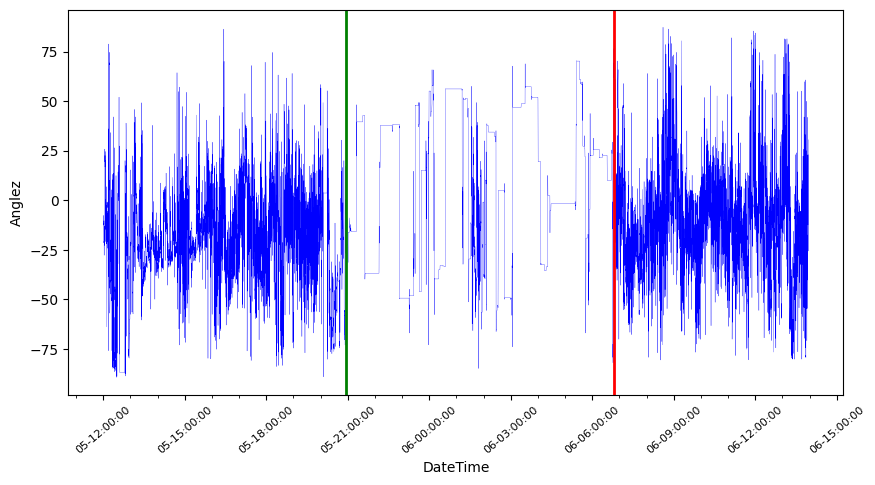

In [26]:
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot()
ax.plot(df_subset['date_time'], df_subset['anglez'], color='blue', linewidth=0.2, label="anglez")
#ax.plot(df_subset['date_time'], df_subset['enmo'], color='blue', linewidth=0.5, label="anglez")
for i in range(0,len(a)):
    ax.axvline(x=a.iloc[i], color='r', linewidth=2)
for j in range(0,len(b)):
    ax.axvline(x=b.iloc[j], color='g', linewidth=2)
#ax.plot(df_subset['date_time'], df_subset['event_wakeup'], color='r', label="wake-up")
#ax.plot(df_subset['date_time'], df_subset['event_onset'], color='g', label="onset")
#ax.legend()
ax.set_xlabel('DateTime')
ax.set_ylabel('Anglez')
ax.xaxis.set_major_locator(mdates.HourLocator(byhour=range(0, 24, 3)))
ax.xaxis.set_minor_locator(mdates.HourLocator(byhour=range(0, 24, 1)))
ax.xaxis.set_major_formatter(mdates.DateFormatter("%d-%H:%M:%S"))
labels = ax.get_xticklabels()
plt.setp(labels, rotation=40, fontsize=8)
plt.show()

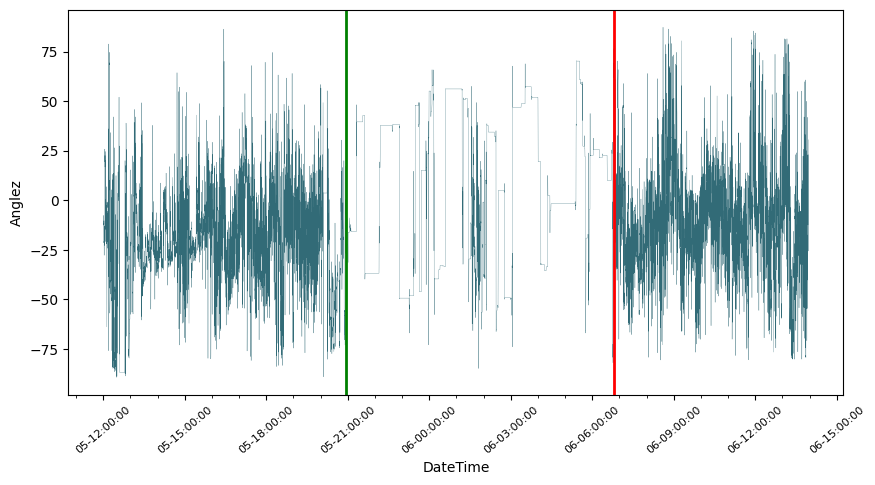

In [28]:
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot()
ax.plot(df_subset['date_time'], df_subset['anglez'], color='#326B77', linewidth=0.2, label="anglez")
#ax.plot(df_subset['date_time'], df_subset['enmo'], color='blue', linewidth=0.5, label="anglez")
for i in range(0,len(a)):
    ax.axvline(x=a.iloc[i], color='r', linewidth=2)
for j in range(0,len(b)):
    ax.axvline(x=b.iloc[j], color='g', linewidth=2)
#ax.plot(df_subset['date_time'], df_subset['event_wakeup'], color='r', label="wake-up")
#ax.plot(df_subset['date_time'], df_subset['event_onset'], color='g', label="onset")
#ax.legend()
ax.set_xlabel('DateTime')
ax.set_ylabel('Anglez')
ax.xaxis.set_major_locator(mdates.HourLocator(byhour=range(0, 24, 3)))
ax.xaxis.set_minor_locator(mdates.HourLocator(byhour=range(0, 24, 1)))
ax.xaxis.set_major_formatter(mdates.DateFormatter("%d-%H:%M:%S"))
labels = ax.get_xticklabels()
plt.setp(labels, rotation=40, fontsize=8)
plt.show()

In [29]:
a

13516   2019-03-06 06:47:00
Name: timestamp, dtype: datetime64[ns]

In [30]:
b

6424   2019-03-05 20:56:00
Name: timestamp, dtype: datetime64[ns]

In [31]:
df_subset.head(5)

,new_row_id,timestamp,row_id,series_id,step,anglez,enmo,hour,event,event_2,...,anglezdiffabs_var_3600,anglezdiffabs_mad_3600,anglezdiffabs_amplit_3600,anglezdiffabs_amplit_3600_min,anglezdiffabs_diff_3600_max,anglezdiffabs_diff_3600_mean,event_wakeup,event_onset,date_time,anglez_norm
0,0,2019-03-05 12:00:40,62435872.0,c75b4b207bea,8.0,-20.734375,44.586182,12,wakeup,Other,...,304.235880,3.406250,111.9375,111.9375,0.0,0.0,0,0,2019-03-05 12:00:40,-0.232155
1,1,2019-03-05 12:00:45,62435872.0,c75b4b207bea,9.0,-21.484375,57.006836,12,wakeup,Other,...,303.437788,3.414062,111.9375,111.9375,0.0,0.0,0,0,2019-03-05 12:00:45,-0.240553
2,2,2019-03-05 12:00:50,62435872.0,c75b4b207bea,10.0,-13.054688,38.299561,12,wakeup,Other,...,302.698374,3.414062,111.9375,111.9375,0.0,0.0,0,0,2019-03-05 12:00:50,-0.146169
3,3,2019-03-05 12:00:55,62435876.0,c75b4b207bea,11.0,-7.652344,8.102417,12,wakeup,Other,...,302.202243,3.414062,111.9375,111.9375,0.0,0.0,0,0,2019-03-05 12:00:55,-0.085681
4,4,2019-03-05 12:01:00,62435876.0,c75b4b207bea,12.0,-9.273438,92.407227,12,wakeup,Other,...,301.693472,3.406250,111.9375,111.9375,0.0,0.0,0,0,2019-03-05 12:01:00,-0.103831


# Step 4: Absolute difference between consecutive values

In [32]:
df_subset["anglezdiffabs"] = df_subset["anglez"].diff().abs().astype(np.float32)
df_subset.head(5)

,new_row_id,timestamp,row_id,series_id,step,anglez,enmo,hour,event,event_2,...,anglezdiffabs_var_3600,anglezdiffabs_mad_3600,anglezdiffabs_amplit_3600,anglezdiffabs_amplit_3600_min,anglezdiffabs_diff_3600_max,anglezdiffabs_diff_3600_mean,event_wakeup,event_onset,date_time,anglez_norm
0,0,2019-03-05 12:00:40,62435872.0,c75b4b207bea,8.0,-20.734375,44.586182,12,wakeup,Other,...,304.235880,3.406250,111.9375,111.9375,0.0,0.0,0,0,2019-03-05 12:00:40,-0.232155
1,1,2019-03-05 12:00:45,62435872.0,c75b4b207bea,9.0,-21.484375,57.006836,12,wakeup,Other,...,303.437788,3.414062,111.9375,111.9375,0.0,0.0,0,0,2019-03-05 12:00:45,-0.240553
2,2,2019-03-05 12:00:50,62435872.0,c75b4b207bea,10.0,-13.054688,38.299561,12,wakeup,Other,...,302.698374,3.414062,111.9375,111.9375,0.0,0.0,0,0,2019-03-05 12:00:50,-0.146169
3,3,2019-03-05 12:00:55,62435876.0,c75b4b207bea,11.0,-7.652344,8.102417,12,wakeup,Other,...,302.202243,3.414062,111.9375,111.9375,0.0,0.0,0,0,2019-03-05 12:00:55,-0.085681
4,4,2019-03-05 12:01:00,62435876.0,c75b4b207bea,12.0,-9.273438,92.407227,12,wakeup,Other,...,301.693472,3.406250,111.9375,111.9375,0.0,0.0,0,0,2019-03-05 12:01:00,-0.103831


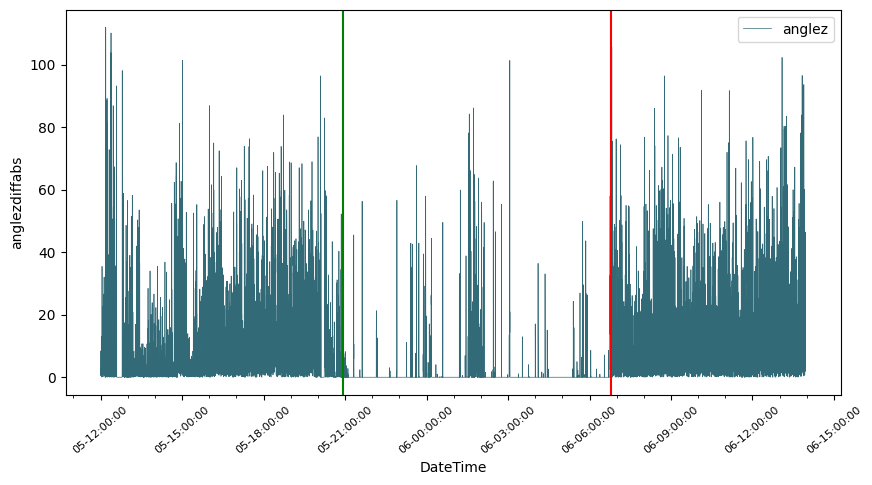

In [34]:
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot()
ax.plot(df_subset['date_time'], df_subset['anglezdiffabs'], color='#326B77', linewidth=0.5, label="anglez")
for i in range(0,len(a)):
    ax.axvline(x=a.iloc[i], color='r')
for j in range(0,len(b)):
    ax.axvline(x=b.iloc[j], color='g')
ax.legend()
ax.set_xlabel('DateTime')
ax.set_ylabel('anglezdiffabs')
ax.xaxis.set_major_locator(mdates.HourLocator(byhour=range(0, 24, 3)))
ax.xaxis.set_minor_locator(mdates.HourLocator(byhour=range(0, 24, 1)))
ax.xaxis.set_major_formatter(mdates.DateFormatter("%d-%H:%M:%S"))
labels = ax.get_xticklabels()
plt.setp(labels, rotation=40, fontsize=8)
plt.show()

# Step 5: Rolling median using a 5-minute window

In [35]:
df_subset['anglezdiffabs_median_60_norm'] = df_subset['anglezdiffabs_median_60'] / max(abs(max(df_subset['anglezdiffabs_median_60'])),abs(min(df_subset['anglezdiffabs_median_60'])))
df_subset.head(5)

,new_row_id,timestamp,row_id,series_id,step,anglez,enmo,hour,event,event_2,...,anglezdiffabs_mad_3600,anglezdiffabs_amplit_3600,anglezdiffabs_amplit_3600_min,anglezdiffabs_diff_3600_max,anglezdiffabs_diff_3600_mean,event_wakeup,event_onset,date_time,anglez_norm,anglezdiffabs_median_60_norm
0,0,2019-03-05 12:00:40,62435872.0,c75b4b207bea,8.0,-20.734375,44.586182,12,wakeup,Other,...,3.406250,111.9375,111.9375,0.0,0.0,0,0,2019-03-05 12:00:40,-0.232155,0.138049
1,1,2019-03-05 12:00:45,62435872.0,c75b4b207bea,9.0,-21.484375,57.006836,12,wakeup,Other,...,3.414062,111.9375,111.9375,0.0,0.0,0,0,2019-03-05 12:00:45,-0.240553,0.134927
2,2,2019-03-05 12:00:50,62435872.0,c75b4b207bea,10.0,-13.054688,38.299561,12,wakeup,Other,...,3.414062,111.9375,111.9375,0.0,0.0,0,0,2019-03-05 12:00:50,-0.146169,0.069854
3,3,2019-03-05 12:00:55,62435876.0,c75b4b207bea,11.0,-7.652344,8.102417,12,wakeup,Other,...,3.414062,111.9375,111.9375,0.0,0.0,0,0,2019-03-05 12:00:55,-0.085681,0.045854
4,4,2019-03-05 12:01:00,62435876.0,c75b4b207bea,12.0,-9.273438,92.407227,12,wakeup,Other,...,3.406250,111.9375,111.9375,0.0,0.0,0,0,2019-03-05 12:01:00,-0.103831,0.045854


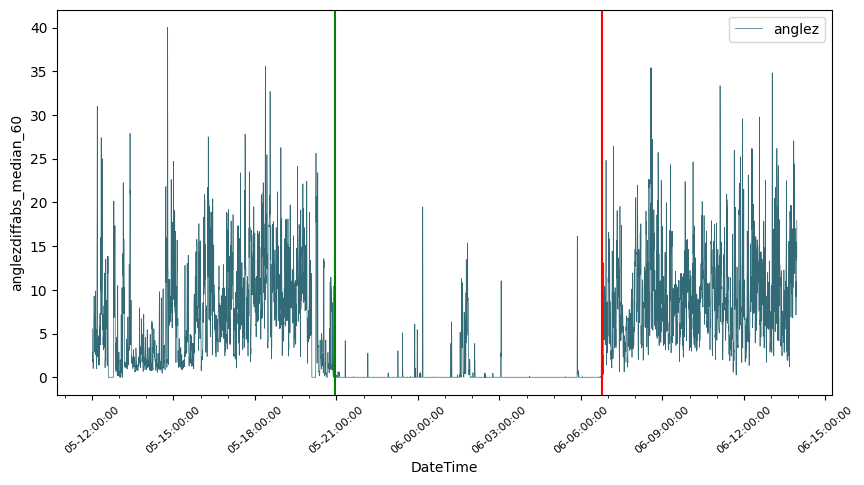

In [38]:
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot()
ax.plot(df_subset['date_time'], df_subset['anglezdiffabs_median_60'], color='#326B77', linewidth=0.5, label="anglez")
for i in range(0,len(a)):
    ax.axvline(x=a.iloc[i], color='r')
for j in range(0,len(b)):
    ax.axvline(x=b.iloc[j], color='g')
ax.legend()
ax.set_xlabel('DateTime')
ax.set_ylabel('anglezdiffabs_median_60')
ax.xaxis.set_major_locator(mdates.HourLocator(byhour=range(0, 24, 3)))
ax.xaxis.set_minor_locator(mdates.HourLocator(byhour=range(0, 24, 1)))
ax.xaxis.set_major_formatter(mdates.DateFormatter("%d-%H:%M:%S"))
labels = ax.get_xticklabels()
plt.setp(labels, rotation=40, fontsize=8)
plt.show()

# Step 6: Detect values < (10ᵗʰ percentile of values in a day × 15)

In [39]:
df_subset['year']=df_subset['date_time'].dt.year
df_subset['month']=df_subset['date_time'].dt.month
df_subset['day']=df_subset['date_time'].dt.day
df_subset['serieid_year_month_day']=df_subset['series_id'].astype(str) +'_'+df_subset['year'].astype(str) + df_subset['month'].astype(str)+ df_subset['day'].astype(str)
df_subset['serieid_night']=df_subset['series_id'].astype(str) +'_'+df_subset['night'].astype(str)

df_subset.head(5)

,new_row_id,timestamp,row_id,series_id,step,anglez,enmo,hour,event,event_2,...,event_wakeup,event_onset,date_time,anglez_norm,anglezdiffabs_median_60_norm,year,month,day,serieid_year_month_day,serieid_night
0,0,2019-03-05 12:00:40,62435872.0,c75b4b207bea,8.0,-20.734375,44.586182,12,wakeup,Other,...,0,0,2019-03-05 12:00:40,-0.232155,0.138049,2019,3,5,c75b4b207bea_201935,c75b4b207bea_1.0
1,1,2019-03-05 12:00:45,62435872.0,c75b4b207bea,9.0,-21.484375,57.006836,12,wakeup,Other,...,0,0,2019-03-05 12:00:45,-0.240553,0.134927,2019,3,5,c75b4b207bea_201935,c75b4b207bea_1.0
2,2,2019-03-05 12:00:50,62435872.0,c75b4b207bea,10.0,-13.054688,38.299561,12,wakeup,Other,...,0,0,2019-03-05 12:00:50,-0.146169,0.069854,2019,3,5,c75b4b207bea_201935,c75b4b207bea_1.0
3,3,2019-03-05 12:00:55,62435876.0,c75b4b207bea,11.0,-7.652344,8.102417,12,wakeup,Other,...,0,0,2019-03-05 12:00:55,-0.085681,0.045854,2019,3,5,c75b4b207bea_201935,c75b4b207bea_1.0
4,4,2019-03-05 12:01:00,62435876.0,c75b4b207bea,12.0,-9.273438,92.407227,12,wakeup,Other,...,0,0,2019-03-05 12:01:00,-0.103831,0.045854,2019,3,5,c75b4b207bea_201935,c75b4b207bea_1.0


In [40]:
min_threshold=0.013
max_threshold=0.04

df_subset['min_threshold'] = 0.005*15
df_subset['max_threshold'] = 0.04*15
df_subset['anglezdiffabs_median_60_perc'] = df_subset.groupby(['serieid_year_month_day'])['anglezdiffabs_median_60'].transform(lambda x: x.quantile(.1))
df_subset['anglezdiffabs_median_60_perc'] = df_subset['anglezdiffabs_median_60_perc'].clip(min_threshold,max_threshold)
df_subset['anglezdiffabs_median_60_perc'] = 15*df_subset['anglezdiffabs_median_60_perc']
df_subset.head(5)

,new_row_id,timestamp,row_id,series_id,step,anglez,enmo,hour,event,event_2,...,anglez_norm,anglezdiffabs_median_60_norm,year,month,day,serieid_year_month_day,serieid_night,min_threshold,max_threshold,anglezdiffabs_median_60_perc
0,0,2019-03-05 12:00:40,62435872.0,c75b4b207bea,8.0,-20.734375,44.586182,12,wakeup,Other,...,-0.232155,0.138049,2019,3,5,c75b4b207bea_201935,c75b4b207bea_1.0,0.075,0.6,0.195
1,1,2019-03-05 12:00:45,62435872.0,c75b4b207bea,9.0,-21.484375,57.006836,12,wakeup,Other,...,-0.240553,0.134927,2019,3,5,c75b4b207bea_201935,c75b4b207bea_1.0,0.075,0.6,0.195
2,2,2019-03-05 12:00:50,62435872.0,c75b4b207bea,10.0,-13.054688,38.299561,12,wakeup,Other,...,-0.146169,0.069854,2019,3,5,c75b4b207bea_201935,c75b4b207bea_1.0,0.075,0.6,0.195
3,3,2019-03-05 12:00:55,62435876.0,c75b4b207bea,11.0,-7.652344,8.102417,12,wakeup,Other,...,-0.085681,0.045854,2019,3,5,c75b4b207bea_201935,c75b4b207bea_1.0,0.075,0.6,0.195
4,4,2019-03-05 12:01:00,62435876.0,c75b4b207bea,12.0,-9.273438,92.407227,12,wakeup,Other,...,-0.103831,0.045854,2019,3,5,c75b4b207bea_201935,c75b4b207bea_1.0,0.075,0.6,0.195


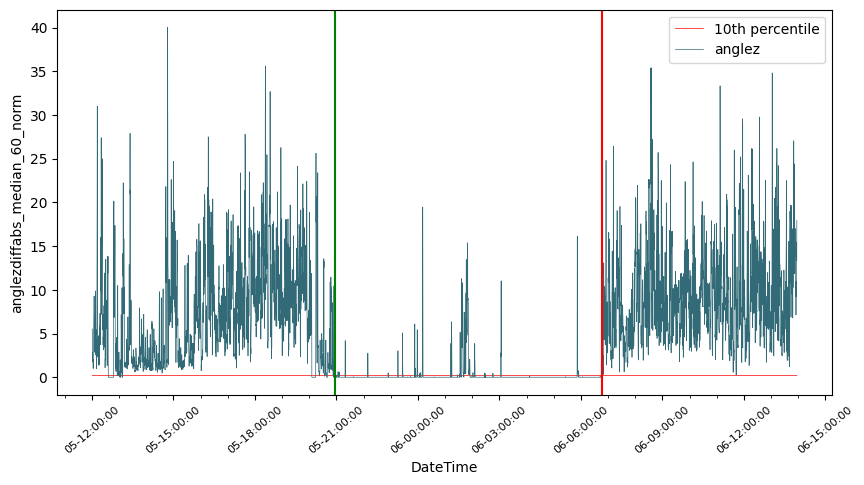

In [43]:
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot()
ax.plot(df_subset['date_time'], df_subset['anglezdiffabs_median_60_perc'], color='red', linewidth=0.5, label="10th percentile")
ax.plot(df_subset['date_time'], df_subset['anglezdiffabs_median_60'], color='#326B77', linewidth=0.5, label="anglez")
for i in range(0,len(a)):
    ax.axvline(x=a.iloc[i], color='r')
for j in range(0,len(b)):
    ax.axvline(x=b.iloc[j], color='g')
ax.legend()
ax.set_xlabel('DateTime')
ax.set_ylabel('anglezdiffabs_median_60_norm')
ax.xaxis.set_major_locator(mdates.HourLocator(byhour=range(0, 24, 3)))
ax.xaxis.set_minor_locator(mdates.HourLocator(byhour=range(0, 24, 1)))
ax.xaxis.set_major_formatter(mdates.DateFormatter("%d-%H:%M:%S"))
labels = ax.get_xticklabels()
plt.setp(labels, rotation=40, fontsize=8)
plt.show()

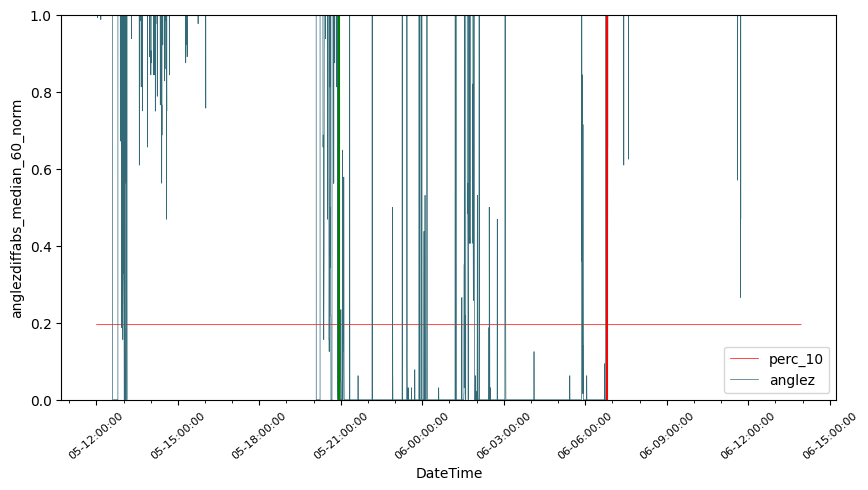

In [44]:
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot()
ax.plot(df_subset['date_time'], df_subset['anglezdiffabs_median_60_perc'], color='red', linewidth=0.5, label="perc_10")
#ax.plot(df_subset['date_time'], df_subset['max_threshold'], color='green', linewidth=0.5, label="max_threshold")
#ax.plot(df_subset['date_time'], df_subset['min_threshold'], color='red', linewidth=0.5, label="min_threshold")
ax.plot(df_subset['date_time'], df_subset['anglezdiffabs_median_60'], color='#326B77', linewidth=0.5, label="anglez")
for i in range(0,len(a)):
    ax.axvline(x=a.iloc[i], color='r')
for j in range(0,len(b)):
    ax.axvline(x=b.iloc[j], color='g')
ax.legend()
ax.set_xlabel('DateTime')
ax.set_ylabel('anglezdiffabs_median_60_norm')
ax.xaxis.set_major_locator(mdates.HourLocator(byhour=range(0, 24, 3)))
ax.xaxis.set_minor_locator(mdates.HourLocator(byhour=range(0, 24, 1)))
ax.xaxis.set_major_formatter(mdates.DateFormatter("%d-%H:%M:%S"))
ax.set_ylim([0, 1])
labels = ax.get_xticklabels()
plt.setp(labels, rotation=40, fontsize=8)
plt.show()

# Step 7: Keep blocks > 30 mins

In [45]:
df_subset['is_static']=np.where(df_subset['anglezdiffabs_median_60']<df_subset['anglezdiffabs_median_60_perc'],1,0)
df_subset['is_static_sum_30min'] = df_subset['is_static'].rolling(window=360, center=True).agg(sum)
df_subset['tmp']=np.where(df_subset['is_static_sum_30min']==360,1,0)
df_subset['tmp_left']=df_subset['tmp'].shift(360 // 2)
df_subset['tmp_right']=df_subset['tmp'].shift(-(360 // 2))
df_subset['is_sleep_block']=np.where((df_subset['tmp_left']==1) | (df_subset['tmp_right']==1),1,0)
df_subset['is_gap']=np.where((df_subset['is_sleep_block']==0),1,0)
df_subset['gap_length'] = df_subset['is_gap'].rolling(window=720, center=True).agg(sum)
df_subset['tmp']=np.where(df_subset['gap_length']==720,1,0)
df_subset['tmp_left']=df_subset['tmp'].shift(720 // 2)
df_subset['tmp_right']=df_subset['tmp'].shift(-(720 // 2))
df_subset['is_large_gap']=np.where((df_subset['tmp_left']==1) | (df_subset['tmp_right']==1),1,0)
df_subset['is_sleep_episode']=np.where((df_subset['is_large_gap']==0),1,0)

In [46]:
df_subset.head(10)

,new_row_id,timestamp,row_id,series_id,step,anglez,enmo,hour,event,event_2,...,is_static,is_static_sum_30min,tmp,tmp_left,tmp_right,is_sleep_block,is_gap,gap_length,is_large_gap,is_sleep_episode
0,0,2019-03-05 12:00:40,62435872.0,c75b4b207bea,8.0,-20.734375,44.586182,12,wakeup,Other,...,0,NaN,0,NaN,1.0,0,1,NaN,1,0
1,1,2019-03-05 12:00:45,62435872.0,c75b4b207bea,9.0,-21.484375,57.006836,12,wakeup,Other,...,0,NaN,0,NaN,1.0,0,1,NaN,1,0
2,2,2019-03-05 12:00:50,62435872.0,c75b4b207bea,10.0,-13.054688,38.299561,12,wakeup,Other,...,0,NaN,0,NaN,1.0,0,1,NaN,1,0
3,3,2019-03-05 12:00:55,62435876.0,c75b4b207bea,11.0,-7.652344,8.102417,12,wakeup,Other,...,0,NaN,0,NaN,1.0,0,1,NaN,1,0
4,4,2019-03-05 12:01:00,62435876.0,c75b4b207bea,12.0,-9.273438,92.407227,12,wakeup,Other,...,0,NaN,0,NaN,1.0,0,1,NaN,1,0
5,5,2019-03-05 12:01:05,62435876.0,c75b4b207bea,13.0,-12.070312,79.589844,12,wakeup,Other,...,0,NaN,0,NaN,1.0,0,1,NaN,1,0
6,6,2019-03-05 12:01:10,62435880.0,c75b4b207bea,14.0,-12.585938,124.572754,12,wakeup,Other,...,0,NaN,0,NaN,1.0,0,1,NaN,1,0
7,7,2019-03-05 12:01:15,62435880.0,c75b4b207bea,15.0,-11.750000,383.789062,12,wakeup,Other,...,0,NaN,0,NaN,1.0,0,1,NaN,1,0
8,8,2019-03-05 12:01:20,62435880.0,c75b4b207bea,16.0,-12.203125,208.374023,12,wakeup,Other,...,0,NaN,0,NaN,1.0,0,1,NaN,1,0
9,9,2019-03-05 12:01:25,62435880.0,c75b4b207bea,17.0,-10.367188,10.101318,12,wakeup,Other,...,0,NaN,0,NaN,1.0,0,1,NaN,1,0


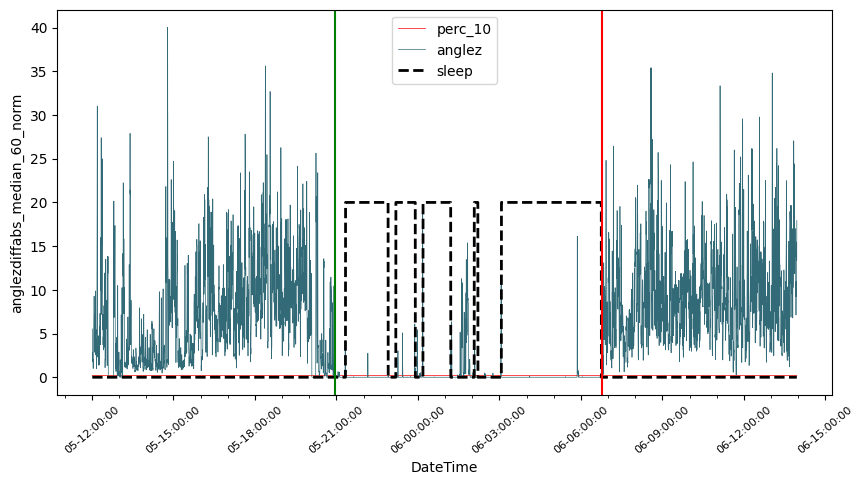

In [53]:
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot()
ax.plot(df_subset['date_time'], df_subset['anglezdiffabs_median_60_perc'], color='red', linewidth=0.5, label="perc_10")
#ax.plot(df_subset['date_time'], df_subset['tmp_left'], color='green', linewidth=0.5, label="tmp_left")
#ax.plot(df_subset['date_time'], df_subset['tmp_right'], color='red', linewidth=0.5, label="tmp_right")
ax.plot(df_subset['date_time'], df_subset['anglezdiffabs_median_60'], color='#326B77', linewidth=0.5, label="anglez")
ax.plot(df_subset['date_time'], df_subset['is_sleep_episode']*20, color='black', linewidth=2, label="sleep", linestyle='dashed')
for i in range(0,len(a)):
    ax.axvline(x=a.iloc[i], color='r')
for j in range(0,len(b)):
    ax.axvline(x=b.iloc[j], color='g')
ax.legend()
ax.set_xlabel('DateTime')
ax.set_ylabel('anglezdiffabs_median_60_norm')
ax.xaxis.set_major_locator(mdates.HourLocator(byhour=range(0, 24, 3)))
ax.xaxis.set_minor_locator(mdates.HourLocator(byhour=range(0, 24, 1)))
ax.xaxis.set_major_formatter(mdates.DateFormatter("%d-%H:%M:%S"))
#ax.set_ylim([0, 2])
labels = ax.get_xticklabels()
plt.setp(labels, rotation=40, fontsize=8)
plt.show()

# Select the longest sleep block per day and extract sleep onset and wakeup times

In [54]:
df_subset[df_subset['event']=='onset'].groupby(df_subset['timestamp']).size()

timestamp
2019-03-05 20:56:00    1
2019-03-05 20:56:05    1
2019-03-05 20:56:10    1
2019-03-05 20:56:15    1
2019-03-05 20:56:20    1
                      ..
2019-03-06 06:46:35    1
2019-03-06 06:46:40    1
2019-03-06 06:46:45    1
2019-03-06 06:46:50    1
2019-03-06 06:46:55    1
Length: 7092, dtype: int64

In [55]:
from datetime import datetime, timedelta
df_subset['timestamp_2']=df_subset['timestamp']+timedelta(hours=12, minutes=0)

In [56]:
df_subset[['timestamp_2','timestamp']]

,timestamp_2,timestamp
0,2019-03-06 00:00:40,2019-03-05 12:00:40
1,2019-03-06 00:00:45,2019-03-05 12:00:45
2,2019-03-06 00:00:50,2019-03-05 12:00:50
3,2019-03-06 00:00:55,2019-03-05 12:00:55
4,2019-03-06 00:01:00,2019-03-05 12:01:00
...,...,...
18671,2019-03-07 01:56:35,2019-03-06 13:56:35
18672,2019-03-07 01:56:40,2019-03-06 13:56:40
18673,2019-03-07 01:56:45,2019-03-06 13:56:45
18674,2019-03-07 01:56:50,2019-03-06 13:56:50


In [57]:
df_subset['pred_diff'] = df_subset['is_sleep_episode'].diff()
df_subset['event'] = df_subset['pred_diff'].replace({-1:'wakeup', 1:'onset', 0:np.nan})
    
test_wakeup = df_subset[df_subset['event']=='wakeup'].groupby(df_subset['timestamp_2'].dt.date).agg('last')
test_onset = df_subset[df_subset['event']=='onset'].groupby(df_subset['timestamp_2'].dt.date).agg('first')
test = pd.concat([test_wakeup, test_onset], ignore_index=True).sort_values('timestamp')
test

,new_row_id,timestamp,row_id,series_id,step,anglez,enmo,hour,event,event_2,...,tmp,tmp_left,tmp_right,is_sleep_block,is_gap,gap_length,is_large_gap,is_sleep_episode,timestamp_2,pred_diff
1,6712,2019-03-05 21:20:00,62442584.0,c75b4b207bea,6720.0,39.5,0.000000,21,onset,Other,...,0,0.0,0.0,1,0,489.0,0,1,2019-03-06 09:20:00,1.0
0,13493,2019-03-06 06:45:05,62449364.0,c75b4b207bea,13501.0,25.5,0.400066,6,wakeup,Other,...,0,0.0,1.0,0,1,480.0,1,0,2019-03-06 18:45:05,-1.0


In [58]:
c=test[(test['event']=='onset')]['timestamp'].iloc[:]
d=test[(test['event']=='wakeup')]['timestamp'].iloc[:]

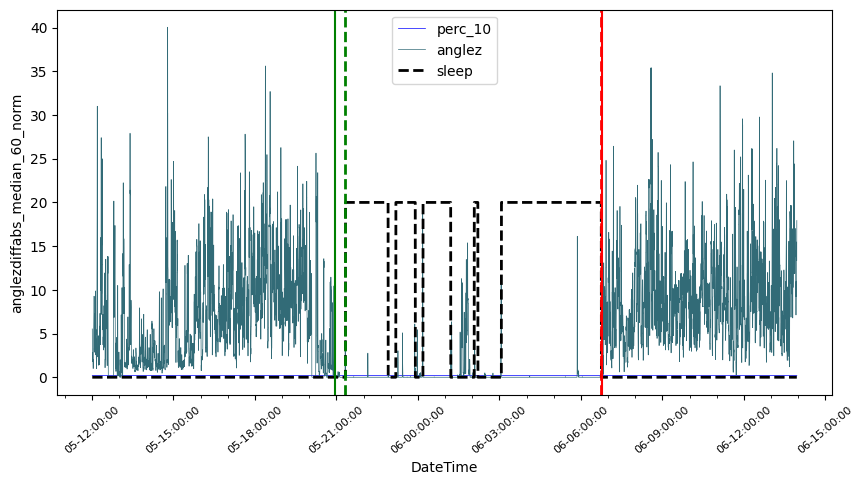

In [61]:
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot()
ax.plot(df_subset['date_time'], df_subset['anglezdiffabs_median_60_perc'], color='blue', linewidth=0.5, label="perc_10")
#ax.plot(df_subset['date_time'], df_subset['tmp_left'], color='green', linewidth=0.5, label="tmp_left")
#ax.plot(df_subset['date_time'], df_subset['tmp_right'], color='red', linewidth=0.5, label="tmp_right")
ax.plot(df_subset['date_time'], df_subset['anglezdiffabs_median_60'], color='#326B77', linewidth=0.5, label="anglez")
ax.plot(df_subset['date_time'], df_subset['is_sleep_episode']*20, color='black', linewidth=2, label="sleep", linestyle='dashed')
for i in range(0,len(a)):
    ax.axvline(x=a.iloc[i], color='red')
for j in range(0,len(b)):
    ax.axvline(x=b.iloc[j], color='green')
for z in range(0,len(c)):
    ax.axvline(x=c.iloc[z], color='green',linestyle='--', linewidth=2)
for w in range(0,len(d)):
    ax.axvline(x=d.iloc[w], color='red',linestyle='--', linewidth=2)
ax.legend()
ax.set_xlabel('DateTime')
ax.set_ylabel('anglezdiffabs_median_60_norm')
ax.xaxis.set_major_locator(mdates.HourLocator(byhour=range(0, 24, 3)))
ax.xaxis.set_minor_locator(mdates.HourLocator(byhour=range(0, 24, 1)))
ax.xaxis.set_major_formatter(mdates.DateFormatter("%d-%H:%M:%S"))
#ax.set_ylim([0, 2])
labels = ax.get_xticklabels()
plt.setp(labels, rotation=40, fontsize=8)
plt.show()

# Summarize the euristhic approach

In [43]:
df_subset["anglezdiffabs"] = df_subset["anglez"].diff().abs().astype(np.float32)


df_subset['year']=df_subset['date_time'].dt.year
df_subset['month']=df_subset['date_time'].dt.month
df_subset['day']=df_subset['date_time'].dt.day
df_subset['serieid_year_month_day']=df_subset['series_id'].astype(str) +'_'+df_subset['year'].astype(str) + df_subset['month'].astype(str)+ df_subset['day'].astype(str)


min_threshold=0.013
max_threshold=0.04

df_subset['min_threshold'] = 0.005*15
df_subset['max_threshold'] = 0.04*15
df_subset['anglezdiffabs_median_60_perc'] = df_subset.groupby(['serieid_year_month_day'])['anglezdiffabs_median_60'].transform(lambda x: x.quantile(.1))
df_subset['anglezdiffabs_median_60_perc'] = df_subset['anglezdiffabs_median_60_perc'].clip(min_threshold,max_threshold)
df_subset['anglezdiffabs_median_60_perc'] = 15*df_subset['anglezdiffabs_median_60_perc']

df_subset['is_static']=np.where(df_subset['anglezdiffabs_median_60']<df_subset['anglezdiffabs_median_60_perc'],1,0)
df_subset['is_static_sum_30min'] = df_subset['is_static'].rolling(window=360, center=True).agg(sum)
df_subset['tmp']=np.where(df_subset['is_static_sum_30min']==360,1,0)
df_subset['tmp_left']=df_subset['tmp'].shift(360 // 2)
df_subset['tmp_right']=df_subset['tmp'].shift(-(360 // 2))
df_subset['is_sleep_block']=np.where((df_subset['tmp_left']==1) | (df_subset['tmp_right']==1),1,0)
df_subset['is_gap']=np.where((df_subset['is_sleep_block']==0),1,0)
df_subset['gap_length'] = df_subset['is_gap'].rolling(window=720, center=True).agg(sum)
df_subset['tmp']=np.where(df_subset['gap_length']==720,1,0)
df_subset['tmp_left']=df_subset['tmp'].shift(720 // 2)
df_subset['tmp_right']=df_subset['tmp'].shift(-(720 // 2))
df_subset['is_large_gap']=np.where((df_subset['tmp_left']==1) | (df_subset['tmp_right']==1),1,0)
df_subset['is_sleep_episode']=np.where((df_subset['is_large_gap']==0),1,0)

df_subset['pred_diff'] = df_subset['is_sleep_episode'].diff()
df_subset['event'] = df_subset['pred_diff'].replace({-1:'wakeup', 1:'onset', 0:np.nan})
    
test_wakeup = df_subset[df_subset['event']=='wakeup'].groupby(df_subset['timestamp'].dt.date).agg('last')
test_onset = df_subset[df_subset['event']=='onset'].groupby(df_subset['timestamp'].dt.date).agg('last')
test = pd.concat([test_wakeup, test_onset], ignore_index=True).sort_values('timestamp')
test

,new_row_id,timestamp,row_id,series_id,step,anglez,enmo,hour,event,event_2,...,tmp,tmp_left,tmp_right,is_sleep_block,is_gap,gap_length,is_large_gap,is_sleep_episode,timestamp_2,pred_diff
5,8046,2019-03-05 23:11:10,62443920.0,c75b4b207bea,8054.0,-49.375000,0.000000,23,onset,Other,...,0,0.0,0.0,0,1,564.0,0,1,2019-03-06 11:11:10,1.0
0,8562,2019-03-05 23:54:10,62444432.0,c75b4b207bea,8570.0,16.343750,0.000000,23,wakeup,Other,...,0,1.0,0.0,0,1,563.0,1,0,2019-03-06 11:54:10,-1.0
1,13493,2019-03-06 06:45:05,62449364.0,c75b4b207bea,13501.0,25.500000,0.400066,6,wakeup,Other,...,0,0.0,1.0,0,1,480.0,1,0,2019-03-06 18:45:05,-1.0
6,23839,2019-03-06 21:07:15,62459712.0,c75b4b207bea,23847.0,77.687500,19.805908,21,onset,Other,...,0,0.0,0.0,0,1,718.0,0,1,2019-03-07 09:07:15,1.0
2,30731,2019-03-07 06:41:35,62466604.0,c75b4b207bea,30739.0,25.718750,0.000000,6,wakeup,Other,...,0,0.0,1.0,0,1,574.0,1,0,2019-03-07 18:41:35,-1.0
7,41370,2019-03-07 21:28:10,62477240.0,c75b4b207bea,41378.0,-59.000000,4.001617,21,onset,Other,...,0,0.0,0.0,1,0,695.0,0,1,2019-03-08 09:28:10,1.0
3,47987,2019-03-08 06:39:35,62483860.0,c75b4b207bea,47995.0,-25.109375,1.000404,6,wakeup,Other,...,0,0.0,1.0,0,1,659.0,1,0,2019-03-08 18:39:35,-1.0
8,58578,2019-03-08 21:22:10,62494448.0,c75b4b207bea,58586.0,-10.281250,0.000000,21,onset,Other,...,0,0.0,0.0,1,0,359.0,0,1,2019-03-09 09:22:10,1.0
4,64175,2019-03-09 05:08:35,62500048.0,c75b4b207bea,64183.0,39.625000,0.000000,5,wakeup,Other,...,0,0.0,1.0,0,1,475.0,1,0,2019-03-09 17:08:35,-1.0


In [44]:
df.columns

Index(['new_row_id', 'timestamp', 'row_id', 'series_id', 'step', 'anglez',
       'enmo', 'hour', 'event', 'event_2',
       ...
       'anglezdiffabs_min_3600', 'anglezdiffabs_var_3600',
       'anglezdiffabs_mad_3600', 'anglezdiffabs_amplit_3600',
       'anglezdiffabs_amplit_3600_min', 'anglezdiffabs_diff_3600_max',
       'anglezdiffabs_diff_3600_mean', 'event_wakeup', 'event_onset',
       'date_time'],
      dtype='object', length=127)

In [45]:
from datetime import datetime, timedelta

def get_events_heuristic_approach(idx) :
    
    #test  = pd.read_parquet(f'/kaggle/input/child-mind-institute-detect-sleep-states/{file}',
    #                filters=[('series_id','=',idx)])
    
    test  = pd.read_parquet('/kaggle/input/gamma-train-series-updated-11-11-2023/train_series_10112023.parquet',
                    filters=[('series_id','=',idx)])
    
    test = feat_eng(test)
    
    df_subset=test[['series_id','step','timestamp','anglez','anglezdiffabs_median_60']]
    df_subset["anglezdiffabs"] = df_subset["anglez"].diff().abs().astype(np.float32)

    df_subset['date_time'] = pd.to_datetime(df_subset['timestamp']).apply(lambda t: t.tz_localize(None))
    df_subset['year']=df_subset['date_time'].dt.year
    df_subset['month']=df_subset['date_time'].dt.month
    df_subset['day']=df_subset['date_time'].dt.day
    df_subset['serieid_year_month_day']=df_subset['series_id'].astype(str) +'_'+df_subset['year'].astype(str) + df_subset['month'].astype(str)+ df_subset['day'].astype(str)
    df_subset['timestamp_2']=df_subset['timestamp']+timedelta(hours=12, minutes=0)

    min_threshold=0.013
    max_threshold=0.04

    df_subset['min_threshold'] = min_threshold*15
    df_subset['max_threshold'] = max_threshold*15
    df_subset['anglezdiffabs_median_60_perc'] = df_subset.groupby(['serieid_year_month_day'])['anglezdiffabs_median_60'].transform(lambda x: x.quantile(.1))
    df_subset['anglezdiffabs_median_60_perc'] = df_subset['anglezdiffabs_median_60_perc'].clip(min_threshold,max_threshold)
    df_subset['anglezdiffabs_median_60_perc'] = 15*df_subset['anglezdiffabs_median_60_perc']

    df_subset['is_static']=np.where(df_subset['anglezdiffabs_median_60']<df_subset['anglezdiffabs_median_60_perc'],1,0)
    df_subset['is_static_sum_30min'] = df_subset['is_static'].rolling(window=360, center=True).agg(sum)
    df_subset['tmp']=np.where(df_subset['is_static_sum_30min']==360,1,0)
    df_subset['tmp_left']=df_subset['tmp'].shift(360 // 2)
    df_subset['tmp_right']=df_subset['tmp'].shift(-(360 // 2))
    df_subset['is_sleep_block']=np.where((df_subset['tmp_left']==1) | (df_subset['tmp_right']==1),1,0)
    df_subset['is_gap']=np.where((df_subset['is_sleep_block']==0),1,0)
    df_subset['gap_length'] = df_subset['is_gap'].rolling(window=720, center=True).agg(sum)
    df_subset['tmp']=np.where(df_subset['gap_length']==720,1,0)
    df_subset['tmp_left']=df_subset['tmp'].shift(720 // 2)
    df_subset['tmp_right']=df_subset['tmp'].shift(-(720 // 2))
    df_subset['is_large_gap']=np.where((df_subset['tmp_left']==1) | (df_subset['tmp_right']==1),1,0)
    df_subset['is_sleep_episode']=np.where((df_subset['is_large_gap']==0),1,0)

    df_subset['pred_diff'] = df_subset['is_sleep_episode'].diff()
    df_subset['event'] = df_subset['pred_diff'].replace({-1:'wakeup', 1:'onset', 0:np.nan})

    test_wakeup = df_subset[df_subset['event']=='wakeup'].groupby(df_subset['timestamp_2'].dt.date).agg('last')
    test_onset = df_subset[df_subset['event']=='onset'].groupby(df_subset['timestamp_2'].dt.date).agg('first')
    test = pd.concat([test_wakeup, test_onset], ignore_index=True).sort_values('timestamp')
    test['score']=0.9
    
    return test

In [46]:
serie_to_see=['c75b4b207bea']

In [47]:
cols_sub = ['series_id','step','event','score']

tests = []

#for idx in tqdm(series_id_test2): 
for idx in tqdm(serie_to_see): 

    test = get_events_heuristic_approach(idx)
    tests.append(test[cols_sub])

  0%|          | 0/1 [00:00<?, ?it/s]

In [48]:
events_submission = pd.concat(tests, ignore_index=True).reset_index(names='row_id')
len(events_submission)

47

In [49]:
%%time
import polars as pl
train_events = (pl.scan_csv('/kaggle/input/child-mind-institute-detect-sleep-states/train_events.csv')
                .with_columns(
                    (
                        (pl.col("timestamp").str.strptime(pl.Datetime, "%Y-%m-%dT%H:%M:%S%Z")),
                        (pl.col("timestamp").str.strptime(pl.Datetime, "%Y-%m-%dT%H:%M:%S%Z").dt.year().alias("year")),
                        (pl.col("timestamp").str.strptime(pl.Datetime, "%Y-%m-%dT%H:%M:%S%Z").dt.month().alias("month")),
                        (pl.col("timestamp").str.strptime(pl.Datetime, "%Y-%m-%dT%H:%M:%S%Z").dt.day().alias("day")),
                        (pl.col("timestamp").str.strptime(pl.Datetime, "%Y-%m-%dT%H:%M:%S%Z").dt.hour().alias("hour")),
                    )
                )
                .collect()
                .to_pandas()
               )

CPU times: user 89 ms, sys: 38.4 ms, total: 127 ms
Wall time: 358 ms


In [50]:
events_submission['score']=0.5

In [51]:
import numpy as np
import pandas as pd
import pandas.api.types
from typing import Dict, List, Tuple

def score(
        solution: pd.DataFrame,
        submission: pd.DataFrame,
        tolerances: Dict[str, List[float]],
        series_id_column_name: str,
        time_column_name: str,
        event_column_name: str,
        score_column_name: str,
        use_scoring_intervals: bool = False,
) -> float:
    """Event Detection Average Precision, an AUCPR metric for event detection in
    time series and video.

    This metric is similar to IOU-threshold average precision metrics commonly
    used in object detection. For events occuring in time series, we replace the
    IOU threshold with a time tolerance.

    Submissions are evaluated on the average precision of detected events,
    averaged over timestamp error tolerance thresholds, averaged over event
    classes.

    Detections are matched to ground-truth events within error tolerances, with
    ambiguities resolved in order of decreasing confidence.

    Detailed Description
    --------------------
    Evaluation proceeds in four steps:

    1. Selection - (optional) Predictions not within a series' scoring
    intervals are dropped.
    2. Assignment - Predicted events are matched with ground-truth events.
    3. Scoring - Each group of predictions is scored against its corresponding
    group of ground-truth events via Average Precision.
    4. Reduction - The multiple AP scores are averaged to produce a single
    overall score.

    Selection

    With each series there may be a defined set of scoring intervals giving the
    intervals of time over which zero or more ground-truth events might be
    annotated in that series. A prediction will be evaluated only if it falls
    within a scoring interval. These scoring intervals can be chosen to improve
    the fairness of evaluation by, for instance, ignoring edge-cases or
    ambiguous events.

    It is recommended that, if used, scoring intervals be provided for training
    data but not test data.

    Assignment

    For each set of predictions and ground-truths within the same `event x
    tolerance x series_id` group, we match each ground-truth to the
    highest-confidence unmatched prediction occurring within the allowed
    tolerance.

    Some ground-truths may not be matched to a prediction and some predictions
    may not be matched to a ground-truth. They will still be accounted for in
    the scoring, however.

    Scoring

    Collecting the events within each `series_id`, we compute an Average
    Precision score for each `event x tolerance` group. The average precision
    score is the area under the (step-wise) precision-recall curve generated by
    decreasing confidence score thresholds over the predictions. In this
    calculation, matched predictions over the threshold are scored as TP and
    unmatched predictions as FP. Unmatched ground-truths are scored as FN.

    Reduction

    The final score is the average of the above AP scores, first averaged over
    tolerance, then over event.

    Parameters
    ----------
    solution : pd.DataFrame, with columns:

        `series_id_column_name` identifier for each time series

        `time_column_name` the time of occurence for each event as a numeric type

        `event_column_name` class label for each event

        The solution contains the time of occurence of one or more types of
        event within one or more time series. The metric expects the solution to
        contain the same event types as those given in `tolerances`.

        When `use_scoring_intervals == True`, you may include `start` and `end`
        events to delimit intervals within which detections will be scored.
        Detected events (from the user submission) outside of these events will
        be ignored.

    submission : pd.DataFrame, with columns as above and in addition:

        `score_column_name` the predicted confidence score for the detected event

    tolerances : Dict[str, List[float]]

        Maps each event class to a list of timestamp tolerances used
        for matching detections to ground-truth events.

    use_scoring_intervals: bool, default False

        Whether to ignore predicted events outside intervals delimited
        by `'start'` and `'end'` events in the solution. When `False`,
        the solution should not include `'start'` and `'end'` events.
        See the examples for illustration.

    Returns
    -------
    event_detection_ap : float
        The mean average precision of the detected events.

    Examples
    --------
    Detecting `'pass'` events in football:
    >>> column_names = {
    ...     'series_id_column_name': 'video_id',
    ...     'time_column_name': 'time',
    ...     'event_column_name': 'event',
    ...     'score_column_name': 'score',
    ... }
    >>> tolerances = {'pass': [1.0]}
    >>> solution = pd.DataFrame({
    ...     'video_id': ['a', 'a'],
    ...     'event': ['pass', 'pass'],
    ...     'time': [0, 15],
    ... })
    >>> submission = pd.DataFrame({
    ...     'video_id': ['a', 'a', 'a'],
    ...     'event': ['pass', 'pass', 'pass'],
    ...     'score': [1.0, 0.5, 1.0],
    ...     'time': [0, 10, 14.5],
    ... })
    >>> score(solution, submission, tolerances, **column_names)
    1.0

    Increasing the confidence score of the false detection above the true
    detections decreases the AP.
    >>> submission.loc[1, 'score'] = 1.5
    >>> score(solution, submission, tolerances, **column_names)
    0.6666666666666666...

    Likewise, decreasing the confidence score of a true detection below the
    false detection also decreases the AP.
    >>> submission.loc[1, 'score'] = 0.5  # reset
    >>> submission.loc[0, 'score'] = 0.0
    >>> score(solution, submission, tolerances, **column_names)
    0.8333333333333333...

    We average AP scores over tolerances. Previously, the detection at 14.5
    would match, but adding smaller tolerances gives AP scores where it does
    not match. This results in both a FN, since the ground-truth wasn't
    detected, and a FP, since the detected event matches no ground-truth.
    >>> tolerances = {'pass': [0.1, 0.2, 1.0]}
    >>> score(solution, submission, tolerances, **column_names)
    0.3888888888888888...

    We also average over time series and over event classes.
    >>> tolerances = {'pass': [0.5, 1.0], 'challenge': [0.25, 0.50]}
    >>> solution = pd.DataFrame({
    ...     'video_id': ['a', 'a', 'b'],
    ...     'event': ['pass', 'challenge', 'pass'],
    ...     'time': [0, 15, 0],  # restart time for new time series b
    ... })
    >>> submission = pd.DataFrame({
    ...     'video_id': ['a', 'a', 'b'],
    ...     'event': ['pass', 'challenge', 'pass'],
    ...     'score': [1.0, 0.5, 1.0],
    ...     'time': [0, 15, 0],
    ... })
    >>> score(solution, submission, tolerances, **column_names)
    1.0

    By adding scoring intervals to the solution, we may choose to ignore
    detections outside of those intervals.
    >>> tolerances = {'pass': [1.0]}
    >>> solution = pd.DataFrame({
    ...     'video_id': ['a', 'a', 'a', 'a'],
    ...     'event': ['start', 'pass', 'pass', 'end'],
    ...     'time': [0, 10, 20, 30],
    ... })
    >>> submission = pd.DataFrame({
    ...     'video_id': ['a', 'a', 'a'],
    ...     'event': ['pass', 'pass', 'pass'],
    ...     'score': [1.0, 1.0, 1.0],
    ...     'time': [10, 20, 40],
    ... })
    >>> score(solution, submission, tolerances, **column_names, use_scoring_intervals=True)
    1.0

    """
    # Validate metric parameters
    assert len(tolerances) > 0, "Events must have defined tolerances."
    assert set(tolerances.keys()) == set(solution[event_column_name]).difference({'start', 'end'}),        (f"Solution column {event_column_name} must contain the same events "
         "as defined in tolerances.")
    assert pd.api.types.is_numeric_dtype(solution[time_column_name]),        f"Solution column {time_column_name} must be of numeric type."

    # Validate submission format
    for column_name in [
        series_id_column_name,
        time_column_name,
        event_column_name,
        score_column_name,
    ]:
        if column_name not in submission.columns:
            raise ParticipantVisibleError(f"Submission must have column '{target_name}'.")

    if not pd.api.types.is_numeric_dtype(submission[time_column_name]):
        raise ParticipantVisibleError(
            f"Submission column '{time_column_name}' must be of numeric type."
        )
    if not pd.api.types.is_numeric_dtype(submission[score_column_name]):
        raise ParticipantVisibleError(
            f"Submission column '{score_column_name}' must be of numeric type."
        )

    # Set these globally to avoid passing around a bunch of arguments
    globals()['series_id_column_name'] = series_id_column_name
    globals()['time_column_name'] = time_column_name
    globals()['event_column_name'] = event_column_name
    globals()['score_column_name'] = score_column_name
    globals()['use_scoring_intervals'] = use_scoring_intervals

    return event_detection_ap(solution, submission, tolerances)


def filter_detections(
        detections: pd.DataFrame, intervals: pd.DataFrame
) -> pd.DataFrame:
    """Drop detections not inside a scoring interval."""
    detection_time = detections.loc[:, time_column_name].sort_values().to_numpy()
    intervals = intervals.to_numpy()
    is_scored = np.full_like(detection_time, False, dtype=bool)

    i, j = 0, 0
    while i < len(detection_time) and j < len(intervals):
        time = detection_time[i]
        int_ = intervals[j]

        # If the detection is prior in time to the interval, go to the next detection.
        if time < int_.left:
            i += 1
        # If the detection is inside the interval, keep it and go to the next detection.
        elif time in int_:
            is_scored[i] = True
            i += 1
        # If the detection is later in time, go to the next interval.
        else:
            j += 1

    return detections.loc[is_scored].reset_index(drop=True)


def match_detections(
        tolerance: float, ground_truths: pd.DataFrame, detections: pd.DataFrame
) -> pd.DataFrame:
    """Match detections to ground truth events. Arguments are taken from a common event x tolerance x series_id evaluation group."""
    detections_sorted = detections.sort_values(score_column_name, ascending=False).dropna()
    is_matched = np.full_like(detections_sorted[event_column_name], False, dtype=bool)
    gts_matched = set()
    for i, det in enumerate(detections_sorted.itertuples(index=False)):
        best_error = tolerance
        best_gt = None

        for gt in ground_truths.itertuples(index=False):
            error = abs(getattr(det, time_column_name) - getattr(gt, time_column_name))
            if error < best_error and gt not in gts_matched:
                best_gt = gt
                best_error = error

        if best_gt is not None:
            is_matched[i] = True
            gts_matched.add(best_gt)

    detections_sorted['matched'] = is_matched

    return detections_sorted


def precision_recall_curve(
        matches: np.ndarray, scores: np.ndarray, p: int
) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    if len(matches) == 0:
        return [1], [0], []

    # Sort matches by decreasing confidence
    idxs = np.argsort(scores, kind='stable')[::-1]
    scores = scores[idxs]
    matches = matches[idxs]

    distinct_value_indices = np.where(np.diff(scores))[0]
    threshold_idxs = np.r_[distinct_value_indices, matches.size - 1]
    thresholds = scores[threshold_idxs]

    # Matches become TPs and non-matches FPs as confidence threshold decreases
    tps = np.cumsum(matches)[threshold_idxs]
    fps = np.cumsum(~matches)[threshold_idxs]

    precision = tps / (tps + fps)
    precision[np.isnan(precision)] = 0
    recall = tps / p  # total number of ground truths might be different than total number of matches

    # Stop when full recall attained and reverse the outputs so recall is non-increasing.
    last_ind = tps.searchsorted(tps[-1])
    sl = slice(last_ind, None, -1)

    # Final precision is 1 and final recall is 0
    return np.r_[precision[sl], 1], np.r_[recall[sl], 0], thresholds[sl]


def average_precision_score(matches: np.ndarray, scores: np.ndarray, p: int) -> float:
    precision, recall, _ = precision_recall_curve(matches, scores, p)
    # Compute step integral
    return -np.sum(np.diff(recall) * np.array(precision)[:-1])


def event_detection_ap(
        solution: pd.DataFrame,
        submission: pd.DataFrame,
        tolerances: Dict[str, List[float]],
) -> float:

    # Ensure solution and submission are sorted properly
    solution = solution.sort_values([series_id_column_name, time_column_name])
    submission = submission.sort_values([series_id_column_name, time_column_name])

    # Extract scoring intervals.
    if use_scoring_intervals:
        intervals = (
            solution
            .query("event in ['start', 'end']")
            .assign(interval=lambda x: x.groupby([series_id_column_name, event_column_name]).cumcount())
            .pivot(
                index='interval',
                columns=[series_id_column_name, event_column_name],
                values=time_column_name,
            )
            .stack(series_id_column_name)
            .swaplevel()
            .sort_index()
            .loc[:, ['start', 'end']]
            .apply(lambda x: pd.Interval(*x, closed='both'), axis=1)
        )

    # Extract ground-truth events.
    ground_truths = (
        solution
        .query("event not in ['start', 'end']")
        .reset_index(drop=True)
    )

    # Map each event class to its prevalence (needed for recall calculation)
    class_counts = ground_truths.value_counts(event_column_name).to_dict()

    # Create table for detections with a column indicating a match to a ground-truth event
    detections = submission.assign(matched = False)

    # Remove detections outside of scoring intervals
    if use_scoring_intervals:
        detections_filtered = []
        for (det_group, dets), (int_group, ints) in zip(
            detections.groupby(series_id_column_name), intervals.groupby(series_id_column_name)
        ):
            assert det_group == int_group
            detections_filtered.append(filter_detections(dets, ints))
        detections_filtered = pd.concat(detections_filtered, ignore_index=True)
    else:
        detections_filtered = detections

    # Create table of event-class x tolerance x series_id values
    aggregation_keys = pd.DataFrame(
        [(ev, tol, vid)
         for ev in tolerances.keys()
         for tol in tolerances[ev]
         for vid in ground_truths[series_id_column_name].unique()],
        columns=[event_column_name, 'tolerance', series_id_column_name],
    )

    # Create match evaluation groups: event-class x tolerance x series_id
    detections_grouped = (
        aggregation_keys
        .merge(detections_filtered, on=[event_column_name, series_id_column_name], how='left')
        .groupby([event_column_name, 'tolerance', series_id_column_name])
    )
    ground_truths_grouped = (
        aggregation_keys
        .merge(ground_truths, on=[event_column_name, series_id_column_name], how='left')
        .groupby([event_column_name, 'tolerance', series_id_column_name])
    )
    # Match detections to ground truth events by evaluation group
    detections_matched = []
    for key in aggregation_keys.itertuples(index=False):
        dets = detections_grouped.get_group(key)
        gts = ground_truths_grouped.get_group(key)
        detections_matched.append(
            match_detections(dets['tolerance'].iloc[0], gts, dets)
        )
    detections_matched = pd.concat(detections_matched)

    # Compute AP per event x tolerance group
    event_classes = ground_truths[event_column_name].unique()
    ap_table = (
        detections_matched
        .query("event in @event_classes")
        .groupby([event_column_name, 'tolerance']).apply(
            lambda group: average_precision_score(
                group['matched'].to_numpy(),
                group[score_column_name].to_numpy(),
                class_counts[group[event_column_name].iat[0]],
            )
        )
    )
    # Average over tolerances, then over event classes
    mean_ap = ap_table.groupby(event_column_name).mean().sum() / len(event_classes)

    return mean_ap

In [52]:
val_solution = train_events[train_events['series_id'].isin(serie_to_see)][['series_id', 'event', 'step']]
#val_solution = train_events[train_events['series_id'].isin(series_id_test2)][['series_id', 'event', 'step']]
val_solution = val_solution[val_solution['step'].notna()]
val_solution = val_solution.reset_index(drop=True)
val_solution = val_solution.reset_index().rename(columns={'index': 'row_id'})

#xgb_submission=xgb_submission[(xgb_submission['score']>0.1)]

#for the weird case
#print(f"Model score: {score(val_solution, events_submission[(events_submission['row_id']<26)],tolerances, **column_names)}")
print(f"Model score: {score(val_solution, events_submission,tolerances, **column_names)}")

Model score: 0.2612830812854442


In [70]:
tolerances = {
    'onset': [12, 36, 60, 90, 120, 150, 180, 240, 300, 360], 
    'wakeup': [12, 36, 60, 90, 120, 150, 180, 240, 300, 360]
}

In [71]:
#for i in series_id_test2:
for i in serie_to_see:
    print(f"Model score - {i} : {score(val_solution[(val_solution['series_id']==i)],events_submission[(events_submission['series_id']==i)],tolerances, **column_names)}")

Model score - c75b4b207bea : 0.2697542533081285


In [60]:
events_submission=events_submission[0:46]

In [62]:
events_submission

,row_id,series_id,step,event,score
0,0,c75b4b207bea,6720.0,onset,0.5
1,1,c75b4b207bea,13501.0,wakeup,0.5
2,2,c75b4b207bea,23847.0,onset,0.5
3,3,c75b4b207bea,30739.0,wakeup,0.5
4,4,c75b4b207bea,41378.0,onset,0.5
5,5,c75b4b207bea,47995.0,wakeup,0.5
6,6,c75b4b207bea,58586.0,onset,0.5
7,7,c75b4b207bea,64183.0,wakeup,0.5
8,8,c75b4b207bea,75439.0,onset,0.5
9,9,c75b4b207bea,81548.0,wakeup,0.5


In [55]:
val_solution

,row_id,series_id,event,step
0,0,c75b4b207bea,onset,6432.0
1,1,c75b4b207bea,wakeup,13524.0
2,2,c75b4b207bea,onset,23844.0
3,3,c75b4b207bea,wakeup,30780.0
4,4,c75b4b207bea,onset,41412.0
5,5,c75b4b207bea,wakeup,48060.0
6,6,c75b4b207bea,onset,58584.0
7,7,c75b4b207bea,wakeup,65256.0
8,8,c75b4b207bea,onset,75420.0
9,9,c75b4b207bea,wakeup,82524.0


In [63]:
val_solution['event2']=val_solution['event']
val_solution['step2']=val_solution['step']
events_submission2 = pd.merge(events_submission, val_solution[['event2','step2','row_id']], how="left",on="row_id")
events_submission2['difference']=events_submission2['step']-events_submission2['step2']
events_submission2

,row_id,series_id,step,event,score,event2,step2,difference
0,0,c75b4b207bea,6720.0,onset,0.5,onset,6432.0,288.0
1,1,c75b4b207bea,13501.0,wakeup,0.5,wakeup,13524.0,-23.0
2,2,c75b4b207bea,23847.0,onset,0.5,onset,23844.0,3.0
3,3,c75b4b207bea,30739.0,wakeup,0.5,wakeup,30780.0,-41.0
4,4,c75b4b207bea,41378.0,onset,0.5,onset,41412.0,-34.0
5,5,c75b4b207bea,47995.0,wakeup,0.5,wakeup,48060.0,-65.0
6,6,c75b4b207bea,58586.0,onset,0.5,onset,58584.0,2.0
7,7,c75b4b207bea,64183.0,wakeup,0.5,wakeup,65256.0,-1073.0
8,8,c75b4b207bea,75439.0,onset,0.5,onset,75420.0,19.0
9,9,c75b4b207bea,81548.0,wakeup,0.5,wakeup,82524.0,-976.0
